# Big Data Management Project 3:
## Analysing Flight Interconnected Data


### Imports and setup

In [1]:
import pyspark
!pip install delta-spark
from delta import configure_spark_with_delta_pip

!pip install graphframes
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType

# 🔧 Spark Session with GraphFrames
builder = pyspark.sql.SparkSession.builder.appName("FlightGraphAnalysis") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.driver.memory", "8g") 

spark = configure_spark_with_delta_pip(
    builder, extra_packages=["graphframes:graphframes:0.8.4-spark3.5-s_2.12"]
).getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions", spark._sc.defaultParallelism)
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 100)

import graphframes as gf # Import the module after installing

### Data selection

In [2]:
df = (spark.read
      .option("header", "true")
      .option("inferSchema", "true")
      .csv("input/2009.csv")
      .select("ORIGIN", "DEST", "FL_DATE", "DISTANCE"))  # selection

df.limit(20).show()

+------+----+----------+--------+
|ORIGIN|DEST|   FL_DATE|DISTANCE|
+------+----+----------+--------+
|   DCA| EWR|2009-01-01|   199.0|
|   EWR| IAD|2009-01-01|   213.0|
|   EWR| DCA|2009-01-01|   199.0|
|   DCA| EWR|2009-01-01|   199.0|
|   IAD| EWR|2009-01-01|   213.0|
|   ATL| EWR|2009-01-01|   745.0|
|   CLE| ATL|2009-01-01|   554.0|
|   DCA| EWR|2009-01-01|   199.0|
|   EWR| DCA|2009-01-01|   199.0|
|   EWR| DCA|2009-01-01|   199.0|
|   DCA| EWR|2009-01-01|   199.0|
|   EWR| DCA|2009-01-01|   199.0|
|   CLE| DCA|2009-01-01|   310.0|
|   DCA| EWR|2009-01-01|   199.0|
|   ORD| EWR|2009-01-01|   719.0|
|   EWR| ORD|2009-01-01|   719.0|
|   ORD| EWR|2009-01-01|   719.0|
|   EWR| ORD|2009-01-01|   719.0|
|   ORD| EWR|2009-01-01|   719.0|
|   EWR| ORD|2009-01-01|   719.0|
+------+----+----------+--------+



### Graph
#### Verticles - airports
#### Edges - flights

In [3]:
#Vertices - irports 
airports_df = df.select(F.col("ORIGIN").alias("id")).union(
    df.select(F.col("DEST").alias("id"))
).distinct()

#Edges - flights
edges_df = df.select(
    F.col("ORIGIN").alias("src"),
    F.col("DEST").alias("dst")
)

#GraphFrame
flights_graph = gf.GraphFrame(airports_df, edges_df)
print("Airports total:", flights_graph.vertices.count())
print("Flights total:", flights_graph.edges.count())

flights_graph.cache()
airports_df.cache()
edges_df.cache()
print(flights_graph)

print("The airports from data: ") 
display(flights_graph.vertices)

print("The flights between airports from data: ")  #routes
display(flights_graph.edges)

Airports total: 296
Flights total: 6429338
GraphFrame(v:[id: string], e:[src: string, dst: string])
The airports from data: 


id
GRR
MFE
DAL
ICT
AVL
PBI
XNA
BFL
JFK
LGB


The flights between airports from data: 


src,dst
DCA,EWR
EWR,IAD
EWR,DCA
DCA,EWR
IAD,EWR
ATL,EWR
CLE,ATL
DCA,EWR
EWR,DCA
EWR,DCA


### Query 1 - Compute different statistics : in-degree, out-degree, total degree and triangle count

### Custom in-degree, out-degree, degree, triangle count

##### First, we computed the in-degree by counting how many flights arrive at each airport (dst). Then, we calculated the out-degree by counting how many flights depart from each airport (src). Finally, we combined both to compute the total degree for each airport by summing in-degree and out-degree. Missing values were handled using coalesce. 
NB teha väham gpt-ks või ära kustutada

In [4]:
# In-degree
in_degree_df = edges_df.groupBy("dst").count() \
    .withColumnRenamed("dst", "id") \
    .withColumnRenamed("count", "inDegree")

# Out-degree
out_degree_df = edges_df.groupBy("src").count() \
    .withColumnRenamed("src", "id") \
    .withColumnRenamed("count", "outDegree")

# Total degree
degree_df = in_degree_df.join(out_degree_df, on="id", how="full_outer") \
    .withColumn("inDegree", F.coalesce(F.col("inDegree"), F.lit(0))) \
    .withColumn("outDegree", F.coalesce(F.col("outDegree"), F.lit(0))) \
    .withColumn("totalDegree", F.col("inDegree") + F.col("outDegree"))

display(degree_df)

id,inDegree,outDegree,totalDegree
ABE,4037,4034,8071
ABI,2490,2490,4980
ABQ,35577,35582,71159
ABY,997,995,1992
ACK,343,342,685
ACT,1052,1053,2105
ACV,3364,3370,6734
ACY,522,522,1044
ADK,103,103,206
ADQ,631,631,1262


##### Calculating the number of unique triangles in the graph by joining edges to form two-step paths (A → B → C) and then checking if a closing edge (C → A) exists. To avoid duplicate counting, we sorted and filtered nodes (A < B < C). The result of Q2 - total triangles in the graph is 16015

In [5]:
edges_filtered = edges_df.select(
    F.least("src", "dst").alias("src"),
    F.greatest("src", "dst").alias("dst")
).distinct().cache()

#two-edges paths
paths_two = edges_filtered.alias("e1").join(
    edges_filtered.alias("e2"),
    F.col("e1.dst") == F.col("e2.src")
).select(
    F.col("e1.src").alias("A"),
    F.col("e1.dst").alias("B"),
    F.col("e2.dst").alias("C")
).filter("A < B AND B < C")

#triangles
triangles = paths_two.join(
    edges_filtered.alias("e3"),
    (F.col("e3.src") == F.col("A")) & (F.col("e3.dst") == F.col("C"))
).select("A", "B", "C").distinct()

#total triangles
triangle_count = triangles.count()
print(f"Total triangles in the graph: {triangle_count}")

display(triangles)

Total triangles in the graph: 16015


A,B,C
CLE,LGA,PBI
CLE,LGA,MSN
CLE,LGA,MDW
CLE,LGA,ORD
CLE,LGA,RDU
CLE,LGA,PHL
CLE,LGA,RSW
CLE,LGA,MIA
CLE,LGA,MCI
CLE,LGA,MCO


### Query  2 - Compute the total number of triangles in the graph

In [6]:
print(f"Total number of triangles in graph: {triangle_count}")

Total number of triangles in graph: 16015


### Query 3 - Compute a centrality measure of your choice natively on Spark using Graphframes

##### Degree Centrality Normalization:  We normalized the totalDegree by dividing it by the total number of airports in the data. Here we can see that the resulting values can be compared proportionally across the entire graph. This can help to understand how much each airport influences the flight network.

In [7]:
degree_centrality = degree_df.withColumn("degreeCentrality", F.col("totalDegree") / airports_df.count())
display(degree_centrality.orderBy("degreeCentrality", ascending=False))

id,inDegree,outDegree,totalDegree,degreeCentrality
ATL,417457,417449,834906,2820.6283783783783
ORD,313769,313848,627617,2120.3277027027025
DFW,264398,264396,528794,1786.4662162162163
DEN,235700,235675,471375,1592.4831081081081
LAX,192916,192879,385795,1303.3614864864865
PHX,183491,183502,366993,1239.8412162162163
IAH,182088,182097,364185,1230.3547297297298
LAS,153984,153993,307977,1040.462837837838
DTW,152075,152081,304156,1027.554054054054
SFO,136532,136488,273020,922.3648648648649


### Query 4 - Implement the PageRank algorithm natively on Spark using Graphframes

In [8]:
g_pagerank = flights_graph.pageRank(resetProbability=0.15, maxIter=10)

print("Top 10 most important airports")
display(g_pagerank.vertices.orderBy(F.desc("pagerank")).limit(10))

Top 10 most important airports


id,pagerank
ATL,18.905010413236518
ORD,12.927110422702082
DFW,11.735613068886845
DEN,9.998483451764816
LAX,7.726101869874797
IAH,7.159305038124472
PHX,7.065371562598674
SLC,7.038754134167305
DTW,7.01996853674844
SFO,5.904248175402539


### Query 5 - Find the group of the most connected airports

In [9]:
#most connected airports based on total degree
most_connected = degree_df.orderBy("totalDegree", ascending=False).limit(10)
display(most_connected)

id,inDegree,outDegree,totalDegree
ATL,417457,417449,834906
ORD,313769,313848,627617
DFW,264398,264396,528794
DEN,235700,235675,471375
LAX,192916,192879,385795
PHX,183491,183502,366993
IAH,182088,182097,364185
LAS,153984,153993,307977
DTW,152075,152081,304156
SFO,136532,136488,273020


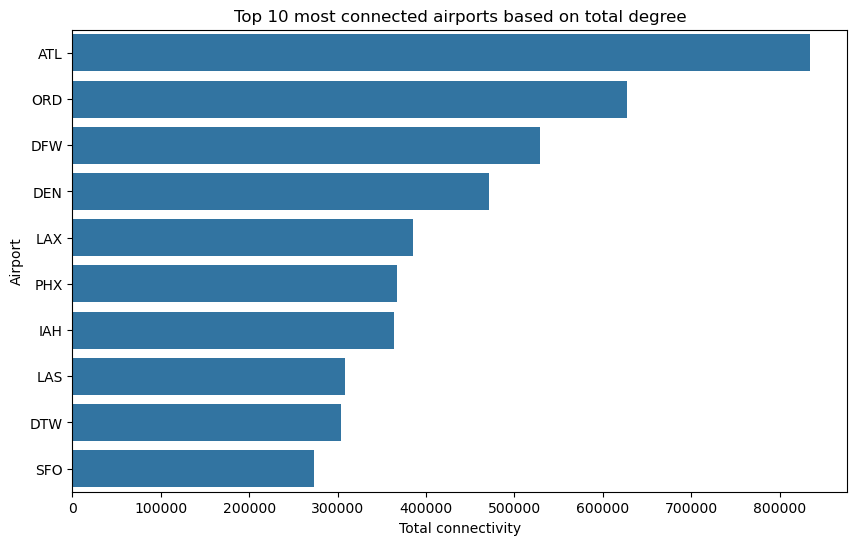

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

most_connected_pd = most_connected.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="totalDegree", y="id", data=most_connected_pd)
plt.xlabel('Total connectivity') #degree
plt.ylabel('Airport')
plt.title('Top 10 most connected airports based on total degree')

plt.show()